In [61]:
import flowermd
import hoomd
from flowermd.library import PolyEthylene, OPLS_AA
from flowermd import Pack
from flowermd.base import Simulation
from cmeutils.visualize import FresnelGSD
import gsd
import matplotlib.pyplot as plt
import numpy as np
from flowermd.utils import get_target_box_mass_density
import freud
import matplotlib.pyplot as plt

In [24]:
molecule = PolyEthylene(num_mols=30, lengths=20)

system = Pack(
    molecules=molecule,
    density=1.1 * u.g/u.cm**3,
)
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA(), auto_scale=True,remove_charges=True, remove_hydrogens=True)

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/core/topology.py:873: UserWarning: An equivalent connection already exists. Providing the existing equivalent Connection.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/core/forcefield.py:358: UserWarning: BondType between atoms opls_135 and opls_136 is missing from the ForceField
  warnings.warn(msg)
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/core/forcefield.py:358: UserWarning: BondType between atoms opls_135 and opls_140 is missing from the ForceField
  warnings.warn(msg)
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/core/forcefield.py:358: UserWarning: BondType between atoms opls_136 and opls_140 is missing from the ForceField
  warnings.warn(msg)
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/core/forcefield.py:358: UserWarning: BondType between atoms opls_136 and opls_136 is missing from t

No charged group detected, skipping electrostatics.


/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:1224: UserWarning: RyckaertBellemansTorsionPotential will be converted to OPLSTorsionPotential.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:560: UserWarning: Orthorhombic box detected
  warnings.warn("Orthorhombic box detected")
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:123: NotYetImplementedWarning: Only writing particle, bond, sangle, proper and improper dihedral information.Special pairs are not currently written to GSD files
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:280: UserWarning: Shifting coordinates to [-L/2, L/2]
  warnings.warn("Shifting coordinates to [-L/2, L/2]")
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:382: UserWarning: 11

Initializing simulation state from a gsd.hoomd.Frame.
[2.94342759e-07 2.94342759e-07 2.94342759e-07] cm
Step 100 of 1000; TPS: 339.83; ETA: 0.0 minutes
Step 200 of 1000; TPS: 596.88; ETA: 0.0 minutes
Step 300 of 1000; TPS: 798.98; ETA: 0.0 minutes
Step 400 of 1000; TPS: 968.58; ETA: 0.0 minutes
Step 500 of 1000; TPS: 1084.45; ETA: 0.0 minutes
Step 600 of 1000; TPS: 1172.33; ETA: 0.0 minutes
Step 700 of 1000; TPS: 1231.61; ETA: 0.0 minutes
Step 800 of 1000; TPS: 1261.95; ETA: 0.0 minutes
Step 900 of 1000; TPS: 1184.13; ETA: 0.0 minutes
Step 1000 of 1000; TPS: 962.22; ETA: 0.0 minutes


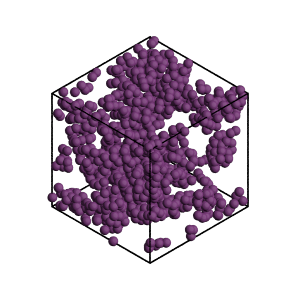

In [25]:
system.hoomd_snapshot
hoomd_forces = system.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()
dict(lj_force.params)


sim = Simulation.from_system(system=system, gsd_write_freq=100, log_write_freq=100, device=cpu, gsd_file_name='pe.gsd')
target_box = get_target_box_mass_density(density=system.density, mass=system.mass.to("g"))
print(target_box)
sim.density.to("g/cm**3")
sim.run_update_volume(n_steps=1000, period=1, kT=1, tau_kt=1, final_box_lengths=target_box)
for writer in sim.operations.writers:
    if isinstance(writer, hoomd.write.GSD):
        writer.flush()

sim_visualizer = FresnelGSD(gsd_file="trajectory.gsd", frame=0, view_axis=(1, 1, 1))
sim_visualizer.view()
sim_visualizer.frame = -1
sim_visualizer.view()

In [4]:
traj = gsd.hoomd.open('trajectory.gsd')

In [91]:
def nop(frame):
    positions = frame.particles.position
    molecule_ids = frame.bonds.group
    temp = positions[0]
    vectors = []
    for i, pos in enumerate(positions):
            if i < len(molecule_ids):
                vectors.append(np.stack(pos) - np.stack(temp))
                temp = pos
    vectors = np.array(vectors[1:])
    return vectors

In [92]:
nematic = freud.order.Nematic()
import time
start = time.process_time()
orders = []
frames = []
count = 0
for frame in traj:
    count += 1
    frames.append(count)
    nematic.compute(nop(frame))
    orders.append(nematic.order)
    print("Nematic Order Parameter:", nematic.order)
print("Time taken:", time.process_time() - start, "s")

Nematic Order Parameter: 0.10096891969442368
Nematic Order Parameter: 0.08584108203649521
Nematic Order Parameter: 0.07882535457611084
Nematic Order Parameter: 0.07047899067401886
Nematic Order Parameter: 0.03957214578986168
Nematic Order Parameter: 0.022090047597885132
Nematic Order Parameter: 0.01838989369571209
Nematic Order Parameter: 0.0187295563519001
Nematic Order Parameter: 0.016657257452607155
Nematic Order Parameter: 0.01782318949699402
Nematic Order Parameter: 0.016546186059713364
Time taken: 1.0399402999999978 s


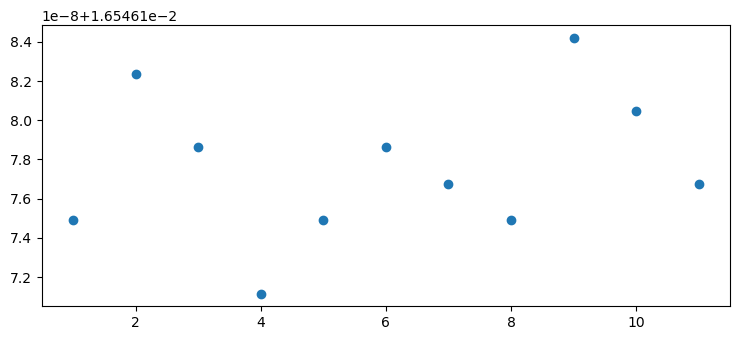

In [87]:
plt.scatter(frames, orders)